In [10]:
# Langkah 1 : Memuat dan menampilkan data
import pandas as pd

# Load the data from the uploaded Excel file
file_path = 'data.xlsx'
data_ikan = pd.read_excel(file_path)

# Display the first few rows of the dataset to understand its structure
data_ikan.head()


,ID,jenis_ikan,tahun,bulan,berat,lokasi,stok,terjual_harian,kategori_pemasaran,status_penjualan
0,1,Udang,2022,Oktober,0.7,Aceh Utara,50,128,Jual langsung ke masyarakat,Tidak Laris
1,2,Bawal,2020,April,0.9,Aceh Utara,118,84,Suplai ke FNB atau pelaku bisnis lain,Laris
2,3,Tongkol,2022,Desember,2.7,Lhokseumawe,53,105,Penjualan langsung ke pedagang UMKM,Tidak Laris
3,4,Kerapu,2021,Juli,2.0,Lhokseumawe,65,90,Suplai ke FNB atau pelaku bisnis lain,Tidak Laris
4,5,Udang,2022,Februari,0.5,Lhokseumawe,73,64,Penjualan langsung ke pedagang UMKM,Laris


In [43]:
from sklearn.model_selection import train_test_split

# Prepare the data for the decision tree model
features = data_ikan.drop(columns=['ID', 'status_penjualan'])
labels = data_ikan['status_penjualan']

# Convert categorical variables to numeric
features_encoded = pd.get_dummies(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_encoded, labels, test_size=0.3, random_state=42)

print("Jumlah Data Latih X : ", len(X_train),  "Jumlah Data uji X : ", len(X_test), "Jumlah Data Latih Y : ", len(y_train), "Jumlah Data Uji Y : ", len(y_test))


# print(X_train)


Jumlah Data Latih X :  70 Jumlah Data uji X :  30 Jumlah Data Latih Y :  70 Jumlah Data Uji Y :  30


In [44]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Create and train the decision tree classifier
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X_train, y_train)

# Convert feature names and class names to list
feature_names = list(features_encoded.columns)
class_names = list(clf.classes_)

# Plot the decision tree with high quality settings
plt.figure(figsize=(40,20), dpi=300)
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names, rounded=True, precision=2, fontsize=12)
plt.tight_layout()
plt.show()


In [46]:
# Langkah 5 : Mengekstrak atau Mengambil rule dari pohon keputusan

import json
import numpy as np

# Get the tree structure
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
value = clf.tree_.value

# Function to extract rules and save to JSON
def get_rules_to_json(node=0):
    if children_left[node] != children_right[node]:  # non-leaf
        name = feature_names[feature[node]]
        threshold_value = threshold[node]
        left_rule = get_rules_to_json(children_left[node])
        right_rule = get_rules_to_json(children_right[node])
        return {
            "feature": name,
            "threshold": threshold_value,
            "left": left_rule,
            "right": right_rule
        }
    else:  # leaf
        value_counts = value[node]
        class_value = np.argmax(value_counts)
        class_name = class_names[class_value]
        return {
            "class": class_name
        }

# Extract rules and save to JSON file
rules_json = get_rules_to_json()
with open('decision_tree_rules.json', 'w') as f:
    json.dump(rules_json, f, indent=4)

# Output the paths to the saved files
output_paths = {
    'visualization': 'decision_tree_visualization.png',
    'rules': 'decision_tree_rules.json'
}

output_paths


{'visualization': 'decision_tree_visualization.png',
 'rules': 'decision_tree_rules.json'}

In [47]:

#Langkah 6 : Simpan Rule dalam bentuk .txt
import pandas as pd
import json

# Load the JSON rules
with open('decision_tree_rules.json', 'r') as f:
    rules_json = json.load(f)

# Function to classify using the rules from JSON
def classify_with_rules(rules, sample):
    if "class" in rules:
        return rules["class"]
    feature = rules["feature"]
    threshold = rules["threshold"]
    if sample[feature] <= threshold:
        return classify_with_rules(rules["left"], sample)
    else:
        return classify_with_rules(rules["right"], sample)

# Load the test data
file_path_test = 'test.xlsx'
data_test = pd.read_excel(file_path_test)

# Prepare the test data
features_test = data_test.drop(columns=['ID'])
features_encoded_test = pd.get_dummies(features_test)

# Ensure that the test data has the same columns as the training data
missing_cols = set(features_encoded.columns) - set(features_encoded_test.columns)
for c in missing_cols:
    features_encoded_test[c] = 0
features_encoded_test = features_encoded_test[features_encoded.columns]

# Classify each sample in the test data
predictions = features_encoded_test.apply(lambda x: classify_with_rules(rules_json, x), axis=1)

# Output the predictions
data_test['Predicted status_penjualan'] = predictions
data_test.to_excel('predicted_data_test.xlsx', index=False)

predicted_data_test_path = 'predicted_data_test.xlsx'
predicted_data_test_path


'predicted_data_test.xlsx'

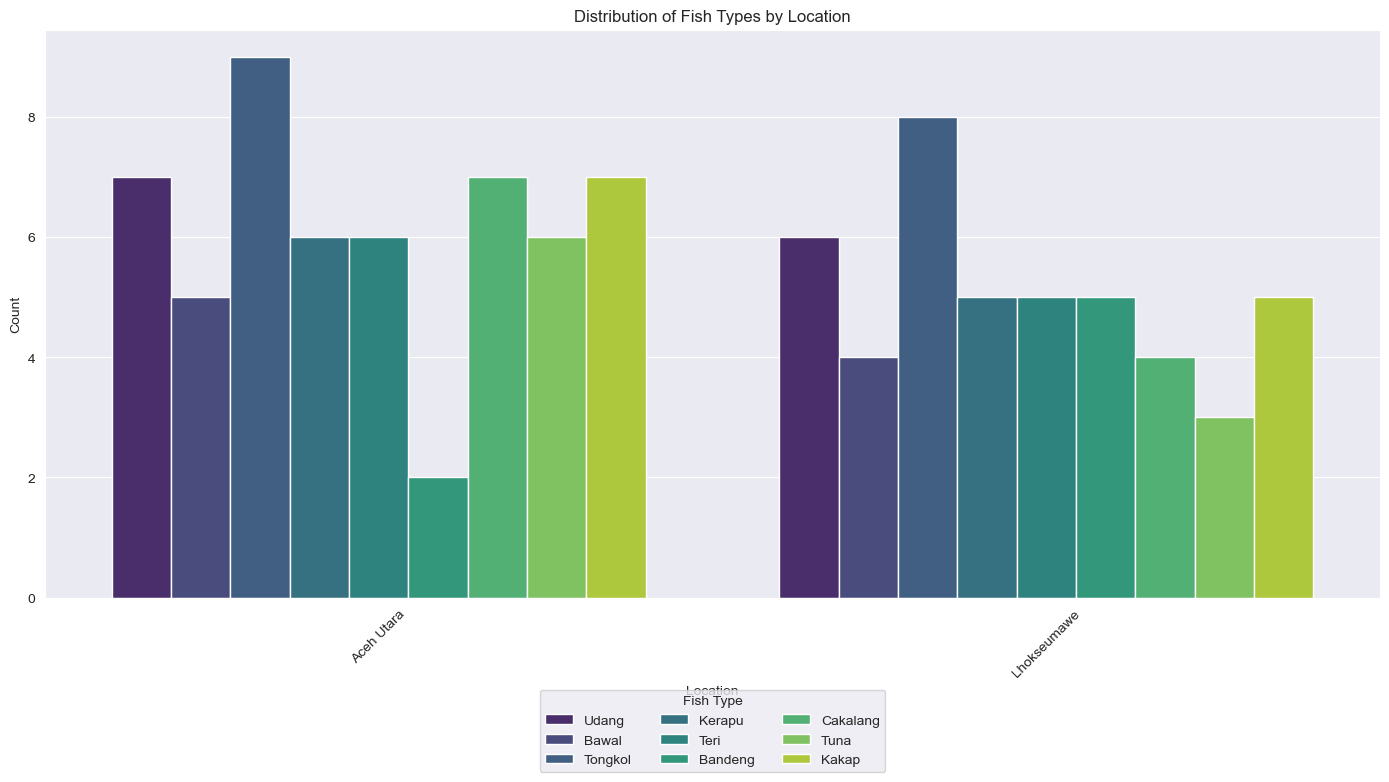

ValueError: Could not interpret input 'Kategori Pemasaran'

<Figure size 1400x800 with 0 Axes>

In [48]:
# Langkah 7 : Visualisasi Data
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the data based on 'lokasi', 'jenis_ikan', and 'Kategori Pemasaran'

# Plot for 'lokasi'
plt.figure(figsize=(14, 8))
ax1 = sns.countplot(data=data_ikan, x='lokasi', hue='jenis_ikan', palette='viridis')
plt.title('Distribution of Fish Types by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Separate the legend and place it below the plot
legend1 = ax1.legend(title='Fish Type', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.savefig('distribution_by_location_with_legend.png', bbox_extra_artists=(legend1,), bbox_inches='tight')
plt.show()

# Plot for 'Kategori Pemasaran'
plt.figure(figsize=(14, 8))
ax2 = sns.countplot(data=data_ikan, x='Kategori Pemasaran', hue='jenis_ikan', palette='viridis')
plt.title('Distribution of Fish Types by Marketing Category')
plt.xlabel('Marketing Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Separate the legend and place it below the plot
legend2 = ax2.legend(title='Fish Type', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.savefig('distribution_by_marketing_category_with_legend.png', bbox_extra_artists=(legend2,), bbox_inches='tight')
plt.show()

# Load the predicted data
predicted_data_test = pd.read_excel('predicted_data_test.xlsx')
predicted_data_test.head()

# Visualize the percentage of 'Laris' and 'Tidak Laris'
status_counts = predicted_data_test['Predicted status_penjualan'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title('Percentage of Predicted Sales Status')
plt.xlabel('Predicted status_penjualan')
plt.ylabel('Percentage')
plt.tight_layout()
plt.savefig('predicted_sales_status_percentage.png')
plt.show()

# Display the table of predicted results
predicted_data_test.head()

# Display the percentage table
status_counts_df = status_counts.reset_index()
status_counts_df.columns = ['Predicted status_penjualan', 'Percentage']
status_counts_df


In [ ]:
# Langkah 8 : Implementasi menggunakan Data Uji

# Load the predicted data
predicted_data_test = pd.read_excel('predicted_data_test.xlsx')

# Display the table of predicted results
print("Predicted Results:")
predicted_data_test



Predictions from Very Fast C4.5:
[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


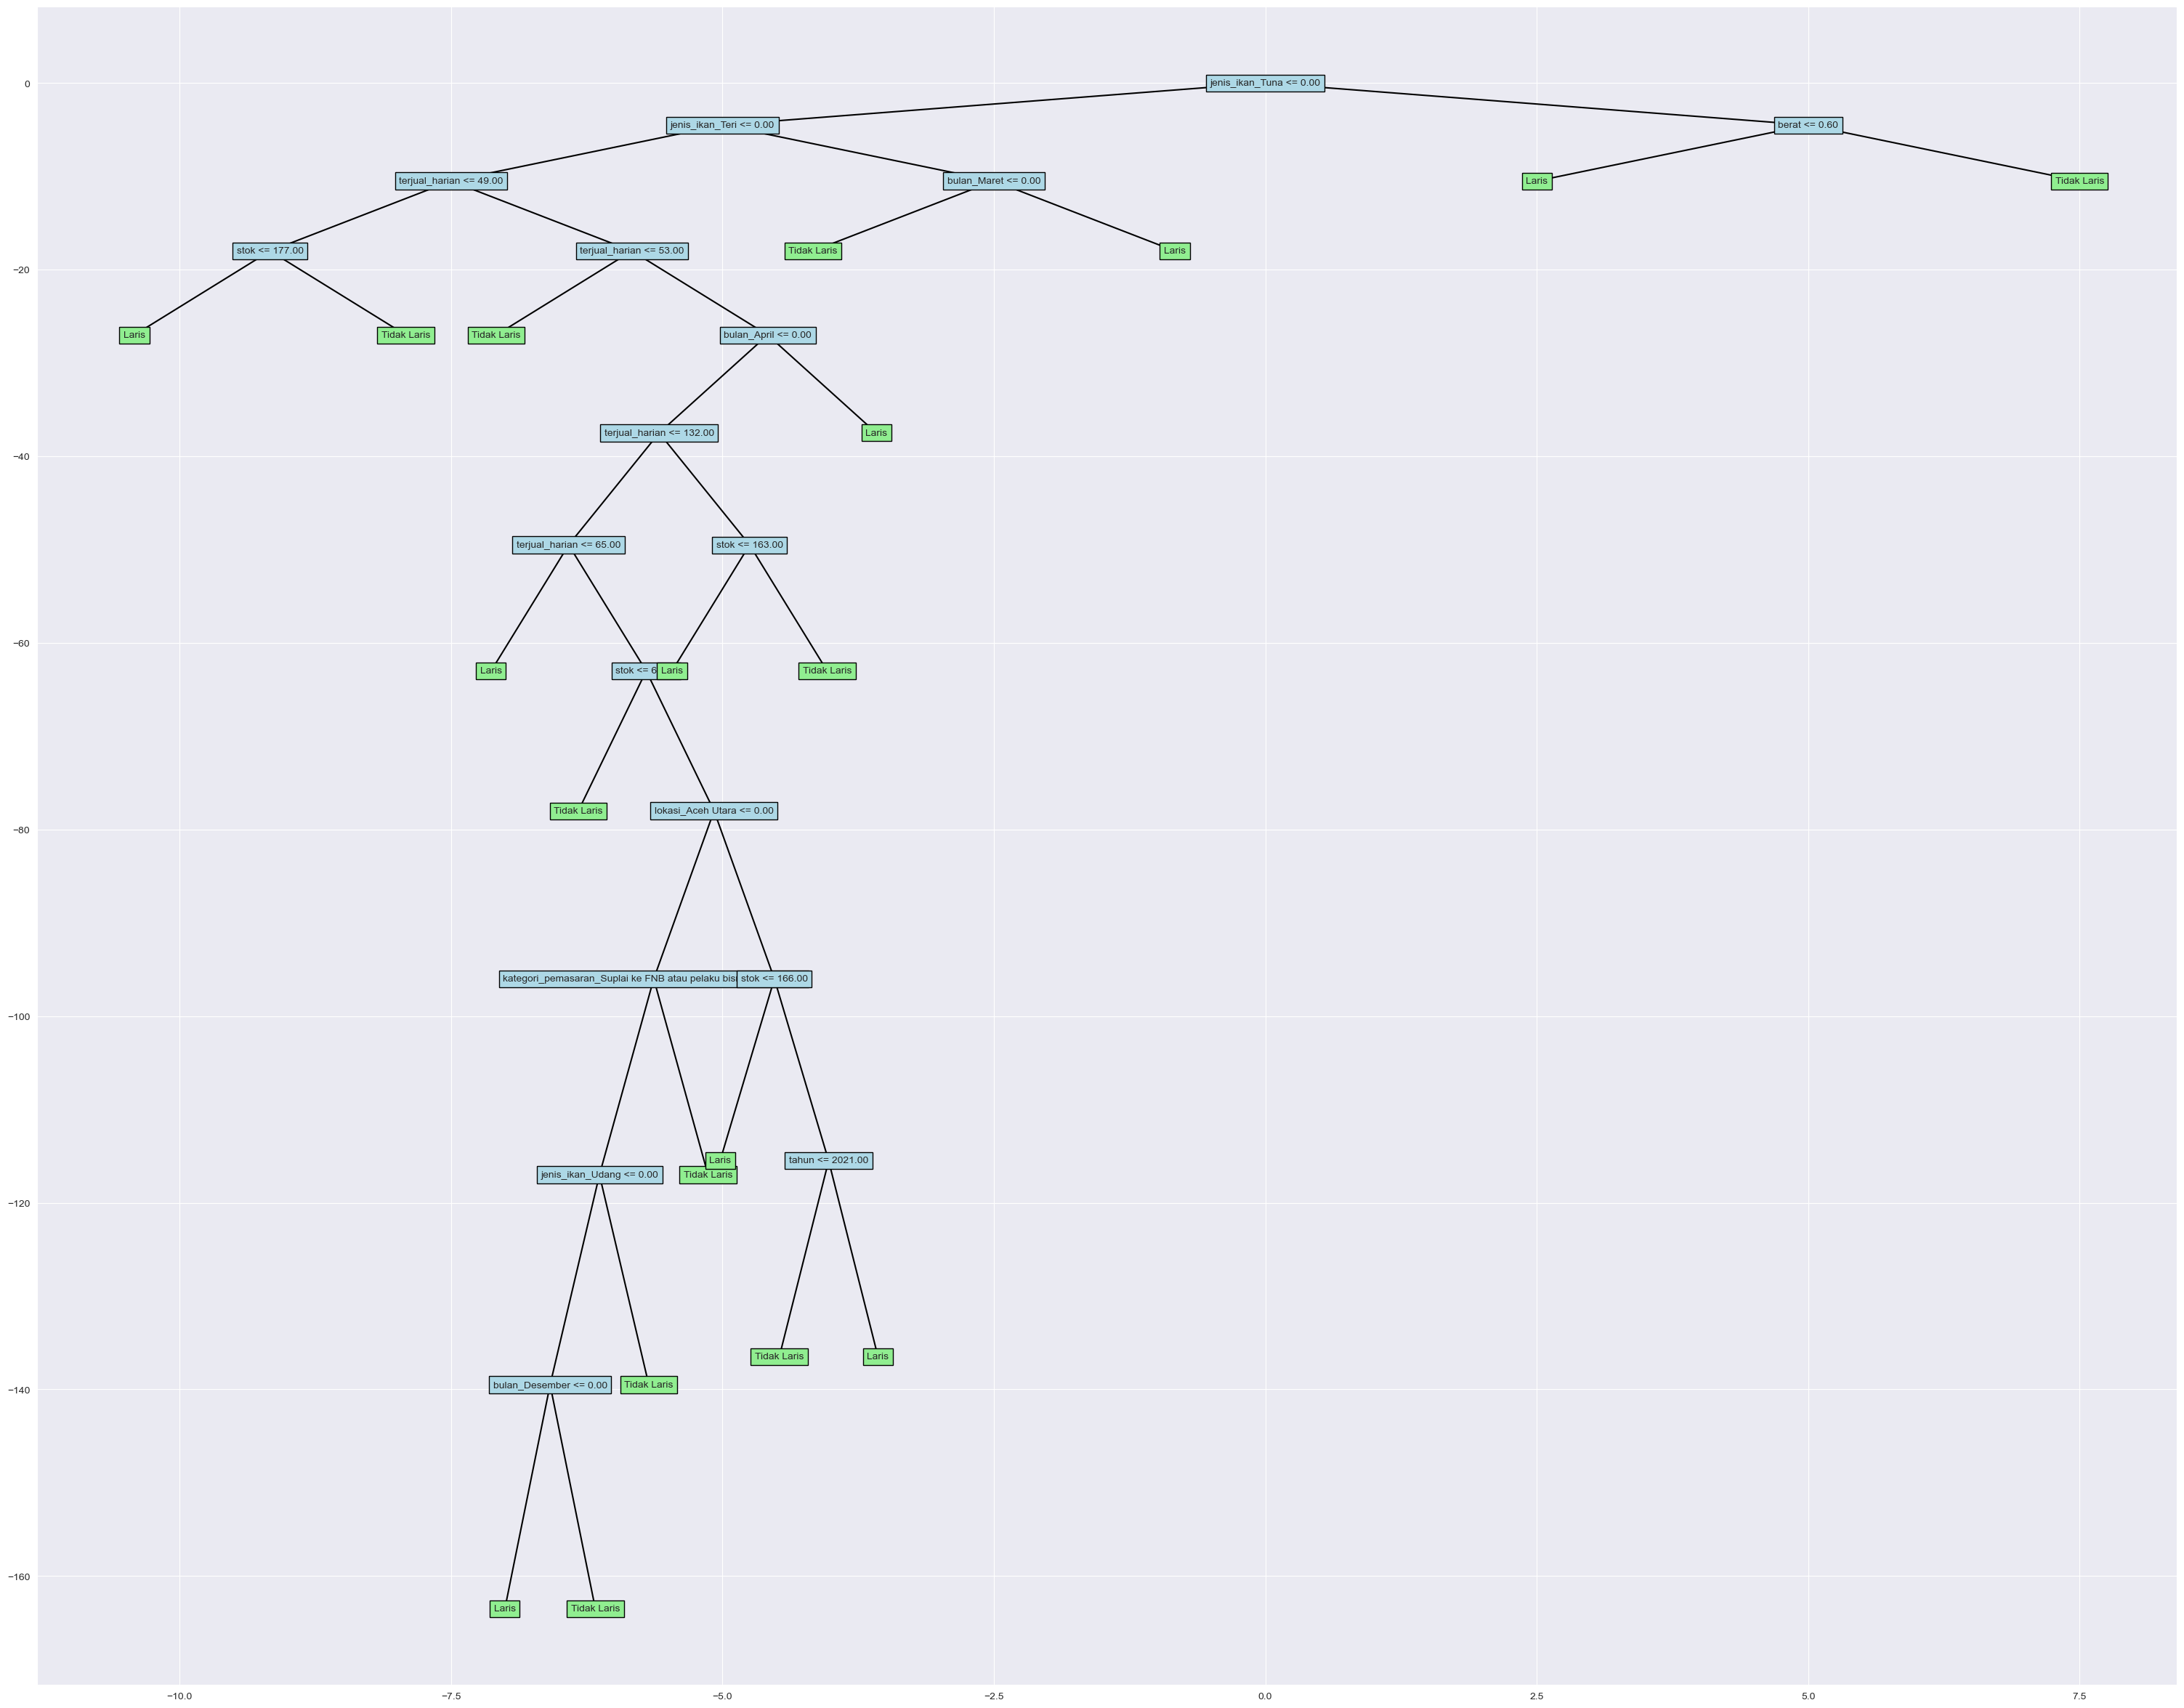

Rule Disimpan Dalam Bentuk Text
Rule Disimpan Dalam Bentuk JSON


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

def very_fast_c45(data_ikan):
    def entropy(y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def info_gain(X, y, threshold):
        parent_entropy = entropy(y)
        left_indices = X <= threshold
        right_indices = X > threshold
        n = len(y)
        n_left, n_right = sum(left_indices), sum(right_indices)
        if n_left == 0 or n_right == 0:
            return 0
        child_entropy = (n_left / n) * entropy(y[left_indices]) + (n_right / n) * entropy(y[right_indices])
        return parent_entropy - child_entropy

    def best_split(X, y):
        best_gain = -1
        best_attr = None
        best_threshold = None
        for attr in range(X.shape[1]):
            thresholds = np.unique(X[:, attr])
            for threshold in thresholds:
                gain = info_gain(X[:, attr], y, threshold)
                if gain > best_gain:
                    best_gain, best_attr, best_threshold = gain, attr, threshold
        return best_attr, best_threshold

    def fit(X, y):
        if len(np.unique(y)) == 1:
            return y[0]
        attr, threshold = best_split(X, y)
        if attr is None:
            return np.bincount(y).argmax() if len(y) > 0 else None  # Handle empty y array
        left_indices = X[:, attr] <= threshold
        right_indices = X[:, attr] > threshold
        if len(left_indices) == 0 or len(right_indices) == 0:  # Handle empty splits
            return np.bincount(y).argmax()
        left_subtree = fit(X[left_indices], y[left_indices])
        right_subtree = fit(X[right_indices], y[right_indices])
        return (attr, threshold, left_subtree, right_subtree)

    def predict_one(x, tree):
        while isinstance(tree, tuple):
            attr, threshold, left_subtree, right_subtree = tree
            if x[attr] <= threshold:
                tree = left_subtree
            else:
                tree = right_subtree
        return tree

    def predict(X, tree):
        return [predict_one(x, tree) for x in X]

    # Prepare the data for the decision tree model
    features = data_ikan.drop(columns=['ID', 'status_penjualan'])
    labels = data_ikan['status_penjualan']

    # Convert categorical variables to numeric
    features_encoded = pd.get_dummies(features, columns=['jenis_ikan', 'bulan', 'lokasi', 'kategori_pemasaran'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_encoded, labels, test_size=0.3, random_state=42)

    # Convert all feature columns to numeric types
    X_train = X_train.apply(pd.to_numeric)
    X_test = X_test.apply(pd.to_numeric)

    # Convert target labels to numeric and handle NaN values
    y_train = y_train.map({'Laris': 1, 'Tidak Laris': 0})
    y_test = y_test.map({'Laris': 1, 'Tidak Laris': 0})

    # Drop any rows with NaN values in the target labels
    y_train = y_train.dropna()
    y_test = y_test.dropna()

    # Align X_train and y_train to make sure they have the same indices
    X_train = X_train.loc[y_train.index]
    X_test = X_test.loc[y_test.index]

    # Ensure X_train and X_test are not empty
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        raise ValueError("Training or testing data has 0 samples after preprocessing.")

    # Prepare the data
    X_train_np = X_train.values
    y_train_np = y_train.values.astype(np.int64)  # Ensure labels are integer type

    # Train the Very Fast C4.5 model
    tree = fit(X_train_np, y_train_np)

    # Predict using the Very Fast C4.5 model
    y_pred_vfc45 = predict(X_test.values, tree)

    # Print out the predictions
    print("Predictions from Very Fast C4.5:")
    print(y_pred_vfc45)

    return tree, features_encoded.columns, ['Tidak Laris', 'Laris']

def plot_tree_vfc45(tree, feature_names, class_names, parent_name=None, depth=0, pos=None, ax=None, vertical_spacing=1.5, horizontal_spacing=1.5):
    if pos is None:
        pos = (0, 0)
    if ax is None:
        fig, ax = plt.subplots(figsize=(38, 30))
        ax.axis('off')

    def get_text_spacing(node_name):
        words = node_name.split()
        if len(words) > 3:
            return 3  # Additional vertical space if more than 3 words
        return 1.5

    if isinstance(tree, tuple):
        attr, threshold, left_subtree, right_subtree = tree
        node_name = f"{feature_names[attr]} <= {threshold:.2f}"
        color = 'lightblue'
    else:
        node_name = f"{class_names[tree]}"
        color = 'lightgreen'

    additional_spacing = get_text_spacing(node_name)
    vertical_spacing += additional_spacing

    ax.text(pos[0], pos[1], node_name, ha='center', va='center', bbox=dict(facecolor=color, edgecolor='black'))

    if parent_name is not None:
        ax.plot([parent_name[0], pos[0]], [parent_name[1], pos[1]], 'k-')

    if isinstance(tree, tuple):
        attr, threshold, left_subtree, right_subtree = tree
        left_pos = (pos[0] - horizontal_spacing / (depth + 1), pos[1] - vertical_spacing)
        right_pos = (pos[0] + horizontal_spacing / (depth + 1), pos[1] - vertical_spacing)
        plot_tree_vfc45(left_subtree, feature_names, class_names, pos, depth + 1, left_pos, ax, vertical_spacing, horizontal_spacing)
        plot_tree_vfc45(right_subtree, feature_names, class_names, pos, depth + 1, right_pos, ax, vertical_spacing, horizontal_spacing)

    if ax is None:
        plt.show()

def extract_rules(tree, feature_names, class_names, rule=None):
    if rule is None:
        rule = []
    if isinstance(tree, tuple):
        attr, threshold, left_subtree, right_subtree = tree
        if "jenis_ikan_" in feature_names[attr] or "bulan_" in feature_names[attr] or "lokasi_" in feature_names[attr] or "kategori_pemasaran_" in feature_names[attr]:
            left_rule = rule + [f"{feature_names[attr]} == True"]
            right_rule = rule + [f"{feature_names[attr]} == False"]
        else:
            left_rule = rule + [f"{feature_names[attr]} <= {threshold:.2f}"]
            right_rule = rule + [f"{feature_names[attr]} > {threshold:.2f}"]
        rules = extract_rules(left_subtree, feature_names, class_names, left_rule)
        rules += extract_rules(right_subtree, feature_names, class_names, right_rule)
        return rules
    else:
        return [f"IF {' AND '.join(rule)} THEN {class_names[tree]}"]

def extract_rules_json(tree, feature_names, class_names):
    rules = extract_rules(tree, feature_names, class_names)
    structured_rules = []

    for rule in rules:
        if ' THEN ' in rule:
            conditions, result = rule.split(' THEN ')
            condition_list = conditions.replace('IF ', '').split(' AND ')
            structured_rules.append({
                'conditions': condition_list,
                'result': result
            })

    return json.dumps(structured_rules, indent=4)

# Load data
data_ikan = pd.read_excel('data.xlsx')  # Ganti dengan path yang sesuai

# Train the model and get the tree
tree, feature_names, class_names = very_fast_c45(data_ikan)

# Plot the Very Fast C4.5 decision tree and save it as a PNG file
fig, ax = plt.subplots(figsize=(38, 30))
plot_tree_vfc45(tree, feature_names, class_names, ax=ax, vertical_spacing=3, horizontal_spacing=5)
plt.savefig('tree_vfc45.png')
plt.show()

# Extract rules and convert to JSON
rules_json = extract_rules_json(tree, feature_names, class_names)
# Simpan aturan ke file .txt
with open('rules_vfc45.txt', 'w') as f:
    f.write(rules_json)
print("Rule Disimpan Dalam Bentuk Text")
# Simpan aturan ke file JSON
with open('rules_vfc45.json', 'w') as f:
    f.write(rules_json)
print("Rule Disimpan Dalam Bentuk JSON")


In [58]:
def load_rules(json_path):
    with open(json_path, 'r') as f:
        rules = json.load(f)
    return rules

def predict_row(row, rules):
    for rule in rules:
        match = True
        for condition in rule['conditions']:
            feature, operator, value = condition.split()
            value = value == 'True' if value in ['True', 'False'] else float(value)
            if operator == '==':
                if not (row[feature] == value):
                    match = False
                    break
            elif operator == '<=':
                if not (row[feature] <= value):
                    match = False
                    break
            elif operator == '>':
                if not (row[feature] > value):
                    match = False
                    break
        if match:
            return rule['result']
    return 'Unknown'

def predict_from_rules(data, rules):
    predictions = data.apply(lambda row: predict_row(row, rules), axis=1)
    return predictions

def main(test_data_path, rules_json_path, output_path):
    # Load test data
    test_data = pd.read_excel(test_data_path)

    # Load rules
    rules = load_rules(rules_json_path)

    # Prepare test data by encoding categorical variables
    features_encoded = pd.get_dummies(test_data, columns=['jenis_ikan', 'bulan', 'lokasi', 'kategori_pemasaran'])

    # Ensure all required columns are present
    required_columns = set([condition.split()[0] for rule in rules for condition in rule['conditions']])
    missing_cols = required_columns - set(features_encoded.columns)
    for col in missing_cols:
        features_encoded[col] = False  # Adding missing columns with default False values

    # Predict using rules
    predictions = predict_from_rules(features_encoded, rules)

    # Add predictions to test data
    test_data['status_penjualan'] = predictions
    
    
    display(test_data)

    # Save the results to an Excel file
    test_data.to_excel(output_path, index=False)
    print(f"Results saved to {output_path}")

# Define paths
test_data_path = 'test.xlsx'
rules_json_path = 'rules_vfc45.json'
output_path = 'test_results.xlsx'

# Call the main function
main(test_data_path, rules_json_path, output_path)

,ID,jenis_ikan,tahun,bulan,berat,lokasi,stok,terjual_harian,kategori_pemasaran,status_penjualan
0,1,Udang,2022,Oktober,0.7,Aceh Utara,50,128,Jual langsung ke masyarakat,Tidak Laris
1,2,Bawal,2020,April,0.9,Aceh Utara,118,84,Suplai ke FNB atau pelaku bisnis lain,Tidak Laris
2,3,Tongkol,2022,Desember,2.7,Lhokseumawe,53,105,Penjualan langsung ke pedagang UMKM,Tidak Laris
3,4,Kerapu,2021,Juli,2.0,Lhokseumawe,65,90,Suplai ke FNB atau pelaku bisnis lain,Tidak Laris
4,5,Udang,2022,Februari,0.5,Lhokseumawe,73,64,Penjualan langsung ke pedagang UMKM,Laris
5,6,Teri,2020,Maret,0.8,Aceh Utara,129,55,Suplai ke FNB atau pelaku bisnis lain,Tidak Laris
6,7,Udang,2020,Januari,2.2,Aceh Utara,51,89,Suplai ke FNB atau pelaku bisnis lain,Tidak Laris
7,8,Tongkol,2021,Mei,0.5,Aceh Utara,177,38,Jual langsung ke masyarakat,Laris
8,9,Kerapu,2022,Januari,0.9,Lhokseumawe,133,127,Penjualan langsung ke pedagang UMKM,Tidak Laris
9,10,Bawal,2022,Agustus,1.9,Aceh Utara,189,110,Penjualan langsung ke pedagang UMKM,Tidak Laris


Results saved to test_results.xlsx


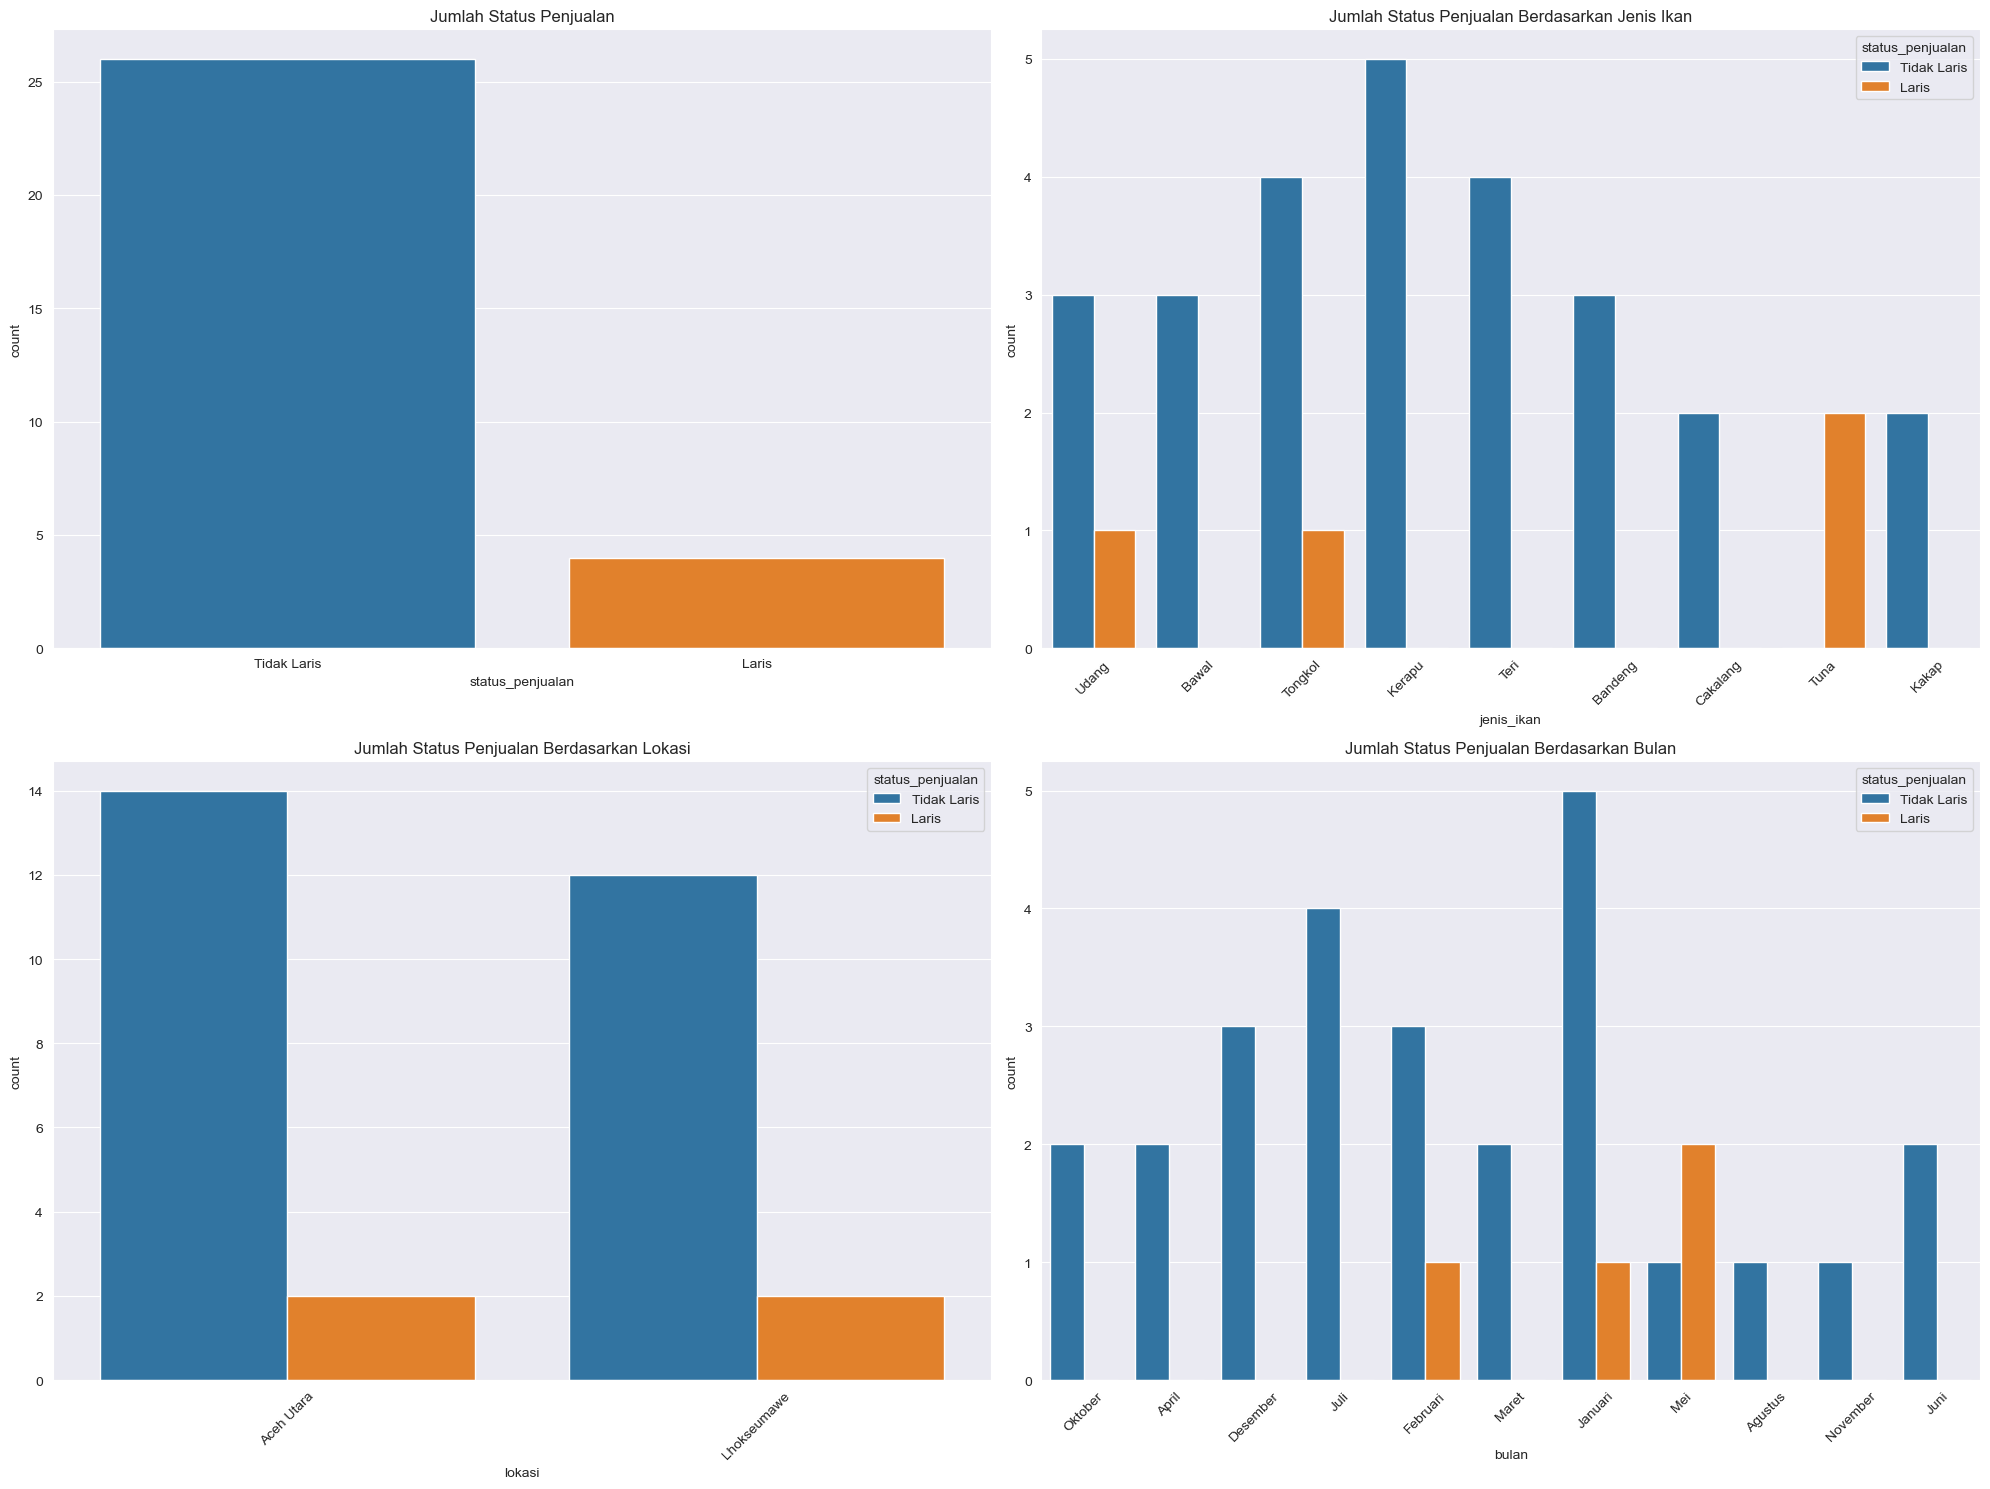

Summary Table:


,Status Penjualan,Jumlah,Persentase
0,Tidak Laris,26,86.666667
1,Laris,4,13.333333



Jenis Ikan Table:


status_penjualan,Laris,Tidak Laris,Total,Laris_Persentase,Tidak Laris_Persentase,Total_Persentase
jenis_ikan,,,,,,
Bandeng,0,3,3,0.0,100.0,100.0
Bawal,0,3,3,0.0,100.0,100.0
Cakalang,0,2,2,0.0,100.0,100.0
Kakap,0,2,2,0.0,100.0,100.0
Kerapu,0,5,5,0.0,100.0,100.0
Teri,0,4,4,0.0,100.0,100.0
Tongkol,1,4,5,20.0,80.0,100.0
Tuna,2,0,2,100.0,0.0,100.0
Udang,1,3,4,25.0,75.0,100.0



Lokasi Table:


status_penjualan,Laris,Tidak Laris,Total,Laris_Persentase,Tidak Laris_Persentase,Total_Persentase
lokasi,,,,,,
Aceh Utara,2,14,16,12.500000,87.500000,100.0
Lhokseumawe,2,12,14,14.285714,85.714286,100.0



Bulan Table:


status_penjualan,Laris,Tidak Laris,Total,Laris_Persentase,Tidak Laris_Persentase,Total_Persentase
bulan,,,,,,
Agustus,0,1,1,0.000000,100.000000,100.0
April,0,2,2,0.000000,100.000000,100.0
Desember,0,3,3,0.000000,100.000000,100.0
Februari,1,3,4,25.000000,75.000000,100.0
Januari,1,5,6,16.666667,83.333333,100.0
Juli,0,4,4,0.000000,100.000000,100.0
Juni,0,2,2,0.000000,100.000000,100.0
Maret,0,2,2,0.000000,100.000000,100.0
Mei,2,1,3,66.666667,33.333333,100.0



Tahun Table:


status_penjualan,Laris,Tidak Laris,Total,Laris_Persentase,Tidak Laris_Persentase,Total_Persentase
tahun,,,,,,
2020,0,7,7,0.000000,100.000000,100.0
2021,1,5,6,16.666667,83.333333,100.0
2022,3,9,12,25.000000,75.000000,100.0
2023,0,5,5,0.000000,100.000000,100.0


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_results(results_path):
    return pd.read_excel(results_path)

def create_tables(data):
    summary_table = data['status_penjualan'].value_counts().reset_index()
    summary_table.columns = ['Status Penjualan', 'Jumlah']
    summary_table['Persentase'] = (summary_table['Jumlah'] / summary_table['Jumlah'].sum()) * 100

    jenis_table = data.groupby(['jenis_ikan', 'status_penjualan']).size().unstack(fill_value=0)
    jenis_table['Total'] = jenis_table.sum(axis=1)
    for col in jenis_table.columns:
        jenis_table[col+'_Persentase'] = (jenis_table[col] / jenis_table['Total']) * 100

    lokasi_table = data.groupby(['lokasi', 'status_penjualan']).size().unstack(fill_value=0)
    lokasi_table['Total'] = lokasi_table.sum(axis=1)
    for col in lokasi_table.columns:
        lokasi_table[col+'_Persentase'] = (lokasi_table[col] / lokasi_table['Total']) * 100

    bulan_table = data.groupby(['bulan', 'status_penjualan']).size().unstack(fill_value=0)
    bulan_table['Total'] = bulan_table.sum(axis=1)
    for col in bulan_table.columns:
        bulan_table[col+'_Persentase'] = (bulan_table[col] / bulan_table['Total']) * 100

    tahun_table = data.groupby(['tahun', 'status_penjualan']).size().unstack(fill_value=0)
    tahun_table['Total'] = tahun_table.sum(axis=1)
    for col in tahun_table.columns:
        tahun_table[col+'_Persentase'] = (tahun_table[col] / tahun_table['Total']) * 100

    return summary_table, jenis_table, lokasi_table, bulan_table, tahun_table

def plot_summary(data):
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))

    sns.countplot(data=data, x='status_penjualan', ax=axs[0, 0])
    axs[0, 0].set_title('Jumlah Status Penjualan')

    sns.countplot(data=data, x='jenis_ikan', hue='status_penjualan', ax=axs[0, 1])
    axs[0, 1].set_title('Jumlah Status Penjualan Berdasarkan Jenis Ikan')
    axs[0, 1].tick_params(axis='x', rotation=45)

    sns.countplot(data=data, x='lokasi', hue='status_penjualan', ax=axs[1, 0])
    axs[1, 0].set_title('Jumlah Status Penjualan Berdasarkan Lokasi')
    axs[1, 0].tick_params(axis='x', rotation=45)

    sns.countplot(data=data, x='bulan', hue='status_penjualan', ax=axs[1, 1])
    axs[1, 1].set_title('Jumlah Status Penjualan Berdasarkan Bulan')
    axs[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('summary_plots.png')
    plt.show()

def main(results_path):
    # Load results data
    data = load_results(results_path)

    # Create summary tables
    summary_table, jenis_table, lokasi_table, bulan_table, tahun_table = create_tables(data)
    # Plot summary
    plot_summary(data)
    # Print summary tables
    print("Summary Table:")
    display(summary_table)
    print("\nJenis Ikan Table:")
    display(jenis_table)
    print("\nLokasi Table:")
    display(lokasi_table)
    print("\nBulan Table:")
    display(bulan_table)
    print("\nTahun Table:")
    display(tahun_table)

    # Save summary tables to Excel
    with pd.ExcelWriter('summary_tables.xlsx') as writer:
        summary_table.to_excel(writer, sheet_name='Summary')
        jenis_table.to_excel(writer, sheet_name='Jenis Ikan')
        lokasi_table.to_excel(writer, sheet_name='Lokasi')
        bulan_table.to_excel(writer, sheet_name='Bulan')
        tahun_table.to_excel(writer, sheet_name='Tahun')

    

# Define path to results
results_path = 'test_results.xlsx'

# Call the main function
main(results_path)
